In [ ]:

%cd /content/

/content


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"


In [ ]:
pwd

'/content'

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/.shortcut-targets-by-id/1ry8T9P0opVkjlg9PPLuNrExym-o1V5JI/Kaggle


In [ ]:
#Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import os
import random

In [ ]:
masks = pd.read_csv('/kaggle/input/lab1-part3-imageclassification/train_df.csv')
masks['EncodedPixels'] = masks['EncodedPixels'].astype('string')

In [ ]:
#Getting images from train folder

def get_train_image(name: str):
    path = f'/kaggle/input/lab1-part3-imageclassification/Train_images/Train_images/{name}'
    print(f'Image path: {path}')
    try:
        image = cv2.imread(path)
        if image is None:
            raise Exception("Failed to read image")
        return image
    except Exception as e:
        print(f"Error reading image: {str(e)}")
        return None

In [ ]:
#Extracting features of the images

def get_train_image(name: str):
    path = f'/kaggle/input/lab1-part3-imageclassification/Train_images/Train_images/{name}'
    print(f'Image path: {path}')
    image = cv2.imread(path)
    return image
def extract_features_from_image(row: pd.Series) -> pd.Series:
    image = np.zeros((768, 768, 3))# get_train_image(row['ImageId'])
    row['ImageHeight'], row['ImageWidth'], _ = image.shape
    return row

masks = masks.apply(lambda x: extract_features_from_image(x), axis=1)

In [ ]:
#Getting the features

def pixels_number(encoded_pixels: str) -> int:
    if pd.isna(encoded_pixels):
        return 0
    return np.array(encoded_pixels.split()[1::2], dtype=int).sum()

masks['ShipAreaPercentage'] = masks.apply(lambda x: pixels_number(x['EncodedPixels']) / (x['ImageHeight'] * x['ImageWidth']) * 100, axis=1)

In [ ]:
train_images_number = masks['ImageId'].nunique()
print(f'There are {train_images_number} train images.')

There are 161747 train images.


In [ ]:
images_without_ships = masks['EncodedPixels'].isna().sum()
print(f'There are {images_without_ships} images without ships.')

There are 125935 images without ships.


In [ ]:
#Function to plot image with encoded pixels and masked image

def show_image_with_encoded_pixels(image_id: str):
    rows = masks[masks['ImageId'] == image_id]
    if len(rows) == 0:
        return
    
    image = get_train_image(image_id)
    image_size, _, _ = image.shape
    ship_count = len(rows)
    all_ships = np.zeros_like(image)

    fig, ax = plt.subplots(ship_count + 1, 3, figsize=(15, 5 * (ship_count + 1)))

    for i in range(ship_count):
        image_info = rows.iloc[i]

        encoded_pixels = np.array(image_info['EncodedPixels'].split(), dtype=int)
        pixels, shift = encoded_pixels[::2], encoded_pixels[1::2]
        ship = np.zeros_like(image)

        for pixel, shift in zip(pixels, shift):
            for j in range(shift):
                cur_pixel = pixel + j - 1
                ship[cur_pixel % image_size, cur_pixel // image_size] = [255, 255, 255]
        all_ships += ship
        
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(ship)
        ax[i, 2].imshow(image * (ship // 255))
        
    ax[ship_count, 0].imshow(image)
    ax[ship_count, 1].imshow(all_ships)
    ax[ship_count, 2].imshow(image * (all_ships // 255))
    plt.show()


Image path: /content/gdrive/MyDrive/Kaggle/Train Image1/TI/train images 1/0a7f650ee.jpg


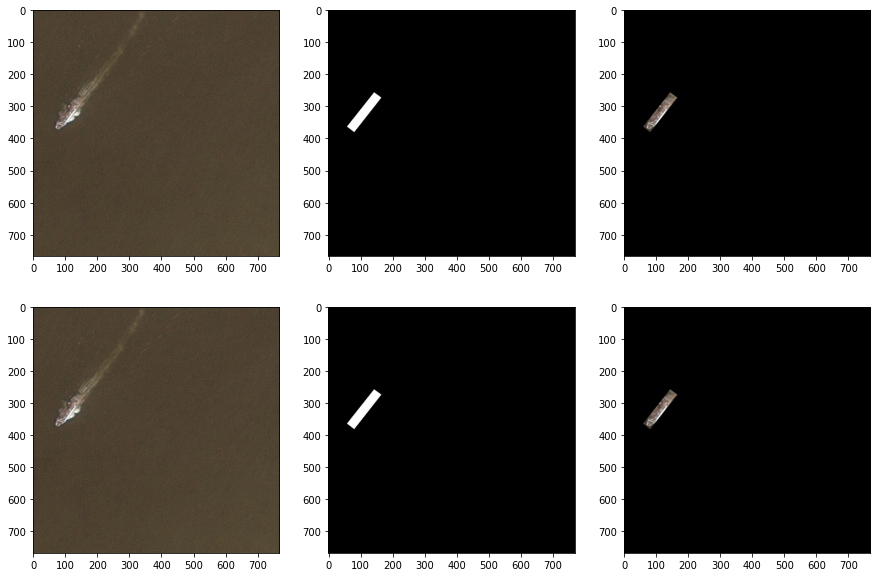

,Unnamed: 0,ImageId,EncodedPixels,ImageHeight,ImageWidth,ShipAreaPercentage
8065,8065,0a7f650ee.jpg,45678 1 46445 3 47211 6 47978 7 48745 9 49512 ...,768,768,0.654093


In [ ]:
import cv2


#Displaying mask for a sample image

image_id = '0a7f650ee.jpg'
show_image_with_encoded_pixels(image_id)
masks[masks['ImageId'] == image_id]

In [ ]:
#Training the UNET model

import random
import os
import tensorflow as tf
from tensorflow import keras

# set the random seed:
RANDOM_SEED = 70
random.seed(RANDOM_SEED)

TRAIN_DIR = '/kaggle/input/lab1-part3-imageclassification/Train_images/Train_images/'
TEST_DIR = '/kaggle/input/lab1-part3-imageclassification/Test/Test/'

In [ ]:
#Importing dataframe

df = pd.read_csv("/kaggle/input/lab1-part3-imageclassification/train_df.csv")
df['EncodedPixels'] = df['EncodedPixels'].astype('string')



# Dataframe that contains the segmentation for each ship in the image. 
instance_segmentation = df

# Dataframe that contains the segmentation of all ships in the image.
image_segmentation = df.groupby(by=['ImageId'])['EncodedPixels'].apply(lambda x: np.nan if pd.isna(x).any() else ' '.join(x)).reset_index()

In [ ]:
#Defining functions that convert mask to rle and back to masks

def rle_to_mask(rle: str, shape=(768, 768)):
    '''
    :param rle: run length encoded pixels as string formated
           shape: (height,width) of array to return 
    :return: numpy 2D array, 1 - mask, 0 - background
    '''
    encoded_pixels = np.array(rle.split(), dtype=int)
    starts = encoded_pixels[::2] - 1
    ends = starts + encoded_pixels[1::2]
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T 

def mask_to_rle(img, shape=(768, 768)) -> str:
    """
    :param img: numpy 2D array, 1 - mask, 0 - background
           shape: (height,width) dimensions of the image 
    :return: run length encoded pixels as string formated
    """
    img = img.astype('float32')
    img = cv2.resize(img, shape, interpolation=cv2.INTER_AREA)
    img = np.stack(np.vectorize(lambda x: 0 if x < 0.1 else 1)(img), axis=1)
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

Data preprocessing since the data is imbalanced

In [ ]:
IMAGES_WITHOUT_SHIPS_NUMBER = 20000

# reduce the number of images without ships for balancing the data
images_without_ships = image_segmentation[image_segmentation['EncodedPixels'].isna()]['ImageId'].values[:IMAGES_WITHOUT_SHIPS_NUMBER]
images_with_ships = image_segmentation[image_segmentation['EncodedPixels'].notna()]['ImageId'].values
images_list = np.append(images_without_ships, images_with_ships)


In [ ]:
VALIDATION_LENGTH = 2000
TEST_LENGTH = 2000
TRAIN_LENGTH = len(images_list) - VALIDATION_LENGTH - TEST_LENGTH
BATCH_SIZE = 16
BUFFER_SIZE = 1000
IMG_SHAPE = (256, 256)
NUM_CLASSES = 2

In [ ]:
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a])

def load_train_image(tensor) -> tuple:
    path = tf.get_static_value(tensor).decode("utf-8")

    image_id = path.split('/')[-1]
    input_image = cv2.imread(path)
    input_image = tf.image.resize(input_image, IMG_SHAPE)
    input_image = tf.cast(input_image, tf.float32) / 255.0

    encoded_mask = image_segmentation[image_segmentation['ImageId'] == image_id].iloc[0]['EncodedPixels']
    input_mask = np.zeros(IMG_SHAPE + (1,), dtype=np.int8)
    if not pd.isna(encoded_mask):
        input_mask = rle_to_mask(encoded_mask)
        input_mask = cv2.resize(input_mask, IMG_SHAPE, interpolation=cv2.INTER_AREA)
        input_mask = np.expand_dims(input_mask, axis=2)
    one_hot_segmentation_mask = one_hot(input_mask, NUM_CLASSES)
    input_mask_tensor = tf.convert_to_tensor(one_hot_segmentation_mask, dtype=tf.float32)
    
    class_weights = tf.constant([0.0005, 0.9995], tf.float32)
    sample_weights = tf.gather(class_weights, indices=tf.cast(input_mask_tensor, tf.int32), name='cast_sample_weights')

    return input_image, input_mask_tensor, sample_weights


In [ ]:
images_list = tf.data.Dataset.list_files([f'{TRAIN_DIR}{name}' for name in images_list], shuffle=True)
train_images = images_list.map(lambda x: tf.py_function(load_train_image, [x], [tf.float32, tf.float32]), num_parallel_calls=tf.data.AUTOTUNE)

validation_dataset = train_images.take(VALIDATION_LENGTH)
test_dataset = train_images.skip(VALIDATION_LENGTH).take(TEST_LENGTH)
train_dataset = train_images.skip(VALIDATION_LENGTH + TEST_LENGTH)

train_batches = (
    train_dataset
    .repeat()
    .batch(BATCH_SIZE))

validation_batches = validation_dataset.batch(BATCH_SIZE)

test_batches = test_dataset.batch(BATCH_SIZE)

In [ ]:
!pip install tensorflow-addons

In [ ]:
#building the Unet model

import keras.backend as K
import tensorflow_addons as tfa

class UNetModel:
    def __init__(self, input_shape=(128, 128, 3)):
        self._model = self._build_model(input_shape)

    @property
    def model(self) -> tf.keras.Model:
        return self._model
    
    def _build_model(self, input_shape, num_classes=NUM_CLASSES) -> tf.keras.Model:
        inputs = tf.keras.layers.Input(shape=input_shape)
        
        filters_list = [16, 32, 64]

        # apply Encoder
        encoder_outputs = self._encoder(input_shape, filters_list)(inputs)
        print(f'Encoder output tensors: {encoder_outputs}')

        # apply Decoder and establishing the skip connections
        x = self._decoder(encoder_outputs, filters_list[::-1])

        # This is the last layers of the model
        last = self._conv_blocks(num_classes, size=1)(x)
        outputs = tf.keras.activations.softmax(last)

        return tf.keras.Model(inputs=inputs, outputs=outputs)
    
    def _encoder(self, input_shape, filters_list):
        inputs = tf.keras.layers.Input(shape=input_shape)
        outputs = []

        model = tf.keras.Sequential()
        x = model(inputs)

        for filters in filters_list:
            x = self._conv_blocks(filters=filters, size=3, apply_instance_norm=True)(x)
            x = self._conv_blocks(filters=filters, size=1, apply_instance_norm=True)(x)
            outputs.append(x)
            x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

        output = self._conv_blocks(filters=128, size=3, apply_batch_norm=True, apply_dropout=False)(x)
        outputs.append(output)

        # Create the feature extraction model
        encoder = tf.keras.Model(inputs=inputs, outputs=outputs, name="encoder")
        encoder.trainable = True
        return encoder
    
    def _decoder(self, encoder_outputs, filters_list):     
        x = encoder_outputs[-1]
        for filters, skip, apply_dropout in zip(filters_list, encoder_outputs[-2::-1], [False] * 4):
            x = self._upsample_block(filters, 3)(x)
            x = tf.keras.layers.Concatenate()([x, skip])
            x = self._conv_blocks(filters, size=3, apply_batch_norm=True, apply_dropout=apply_dropout)(x)
            x = self._conv_blocks(filters, size=1, apply_batch_norm=True)(x)
        return x
    
    def _conv_blocks(self, filters, size, apply_batch_norm=False, apply_instance_norm=False, apply_dropout=False):
        """Downsamples an input. Conv2D => Batchnorm => Dropout => LeakyReLU
            :param:
                filters: number of filters
                size: filter size
                apply_dropout: If True, adds the dropout layer
            :return: Downsample Sequential Model
        """
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(
          tf.keras.layers.Conv2D(filters, size, strides=1,
                                 padding='same', use_bias=False,
                                 kernel_initializer=initializer,))
        if apply_batch_norm:
            result.add(tf.keras.layers.BatchNormalization())
        if apply_instance_norm:
            result.add(tfa.layers.InstanceNormalization())
        result.add(tf.keras.layers.Activation(tfa.activations.mish))
        if apply_dropout:
            result.add(tf.keras.layers.Dropout(0.55))
        return result
    
    def _upsample_block(self, filters, size, apply_dropout=False):
        """Upsamples an input. Conv2DTranspose => Batchnorm => Dropout => LeakyReLU
            :param:
                filters: number of filters
                size: filter size
                apply_dropout: If True, adds the dropout layer
            :return: Upsample Sequential Model
        """
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(
          tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          use_bias=False))
        result.add(tf.keras.layers.BatchNormalization())
        if apply_dropout:
            result.add(tf.keras.layers.Dropout(0.1))
        result.add(tf.keras.layers.Activation(tfa.activations.mish))
        return result
    

In [ ]:
#Defining Losses

def dice(targets, inputs, smooth=1e-6):
    axis = [1,2,3]
    intersection = K.sum(targets * inputs, axis=axis)
    dice = (2 * intersection + smooth) / (K.sum(targets, axis=axis) + K.sum(inputs, axis=axis) + smooth)
    return dice

def bce_loss(targets, inputs, smooth=1e-6):
    axis = [1,2,3]
    loss = K.sum(targets * tf.math.log(inputs + smooth) + (1 - targets) * tf.math.log(1 - inputs + smooth), axis=axis)
    return - loss

def bce_dice_loss(targets, inputs):
    return bce_loss(targets, inputs) - tf.math.log(dice(targets, inputs))

In [ ]:
#Building IOU metric class

class IoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes: int, target_class_ids: list, sparse_y_true: bool, sparse_y_pred: bool,
                 axis: int = -1, name=None, dtype=None):
        super(IoU, self).__init__(name=name, dtype=dtype)
        self.num_classes = num_classes
        self.target_class_ids = target_class_ids
        self.sparse_y_true = sparse_y_true
        self.sparse_y_pred = sparse_y_pred
        self.axis = axis

        # Variable to accumulate the predictions in the confusion matrix.
        self.total_cm = self.add_weight(
            'total_confusion_matrix',
            shape=(num_classes, num_classes),
            initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        """Accumulates the confusion matrix statistics.
        Args:
          y_true: The ground truth values.
          y_pred: The predicted values.
          sample_weight: Optional weighting of each example. Defaults to 1. Can be a
            `Tensor` whose rank is either 0, or the same rank as `y_true`, and must
            be broadcastable to `y_true`.
        Returns:
          Update op.
        """
        
        y_true = tf.reshape(y_true, [-1] + list(y_pred.shape[1:]))
        
        if not self.sparse_y_true:
            y_true = tf.argmax(y_true, axis=self.axis)
        if not self.sparse_y_pred:
            y_pred = tf.argmax(y_pred, axis=self.axis)
            
        y_true = tf.cast(y_true, self._dtype)
        y_pred = tf.cast(y_pred, self._dtype)

        # Flatten the input if its rank > 1.
        if y_pred.shape.ndims > 1:
            y_pred = tf.reshape(y_pred, [-1])

        if y_true.shape.ndims > 1:
            y_true = tf.reshape(y_true, [-1])

        if sample_weight is not None:
            sample_weight = tf.reshape(sample_weight, [-1, 128, 128])
            sample_weight = tf.cast(sample_weight, self._dtype)
            if sample_weight.shape.ndims > 1:
                sample_weight = tf.reshape(sample_weight, [-1])

        # Accumulate the prediction to current confusion matrix.
        current_cm = tf.math.confusion_matrix(y_true, y_pred, self.num_classes, weights=sample_weight, dtype=self._dtype)
        return self.total_cm.assign_add(current_cm)
    
    def reset_state(self):
        tf.keras.backend.set_value(
            self.total_cm, np.zeros((self.num_classes, self.num_classes))
        )
    
    def result(self):
        """Compute the intersection-over-union via the confusion matrix."""
        sum_over_row = tf.cast(
            tf.reduce_sum(self.total_cm, axis=0), dtype=self._dtype)
        sum_over_col = tf.cast(
            tf.reduce_sum(self.total_cm, axis=1), dtype=self._dtype)
        true_positives = tf.cast(
            tf.linalg.tensor_diag_part(self.total_cm), dtype=self._dtype)

        # sum_over_row + sum_over_col = 2 * true_positives + false_positives + false_negatives.
        denominator = sum_over_row + sum_over_col - true_positives

        # Only keep the target classes
        true_positives = tf.gather(true_positives, self.target_class_ids)
        denominator = tf.gather(denominator, self.target_class_ids)

        # If the denominator is 0, we need to ignore the class.
        num_valid_entries = tf.reduce_sum(
            tf.cast(tf.not_equal(denominator, 0), dtype=self._dtype))

        iou = tf.math.divide_no_nan(true_positives, denominator)

        return tf.math.divide_no_nan(
            tf.reduce_sum(iou, name='mean_iou'), num_valid_entries)
    
    def get_config(self):
        config = {
            "num_classes": self.num_classes,
            "target_class_ids": self.target_class_ids,
            "sparse_y_true": self.sparse_y_true,
            "sparse_y_pred": self.sparse_y_pred,
            "axis": self.axis,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

Encoder output tensors: [<KerasTensor: shape=(None, 256, 256, 16) dtype=float32 (created by layer 'encoder')>, <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'encoder')>, <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'encoder')>, <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'encoder')>]
Trainable params: 302896


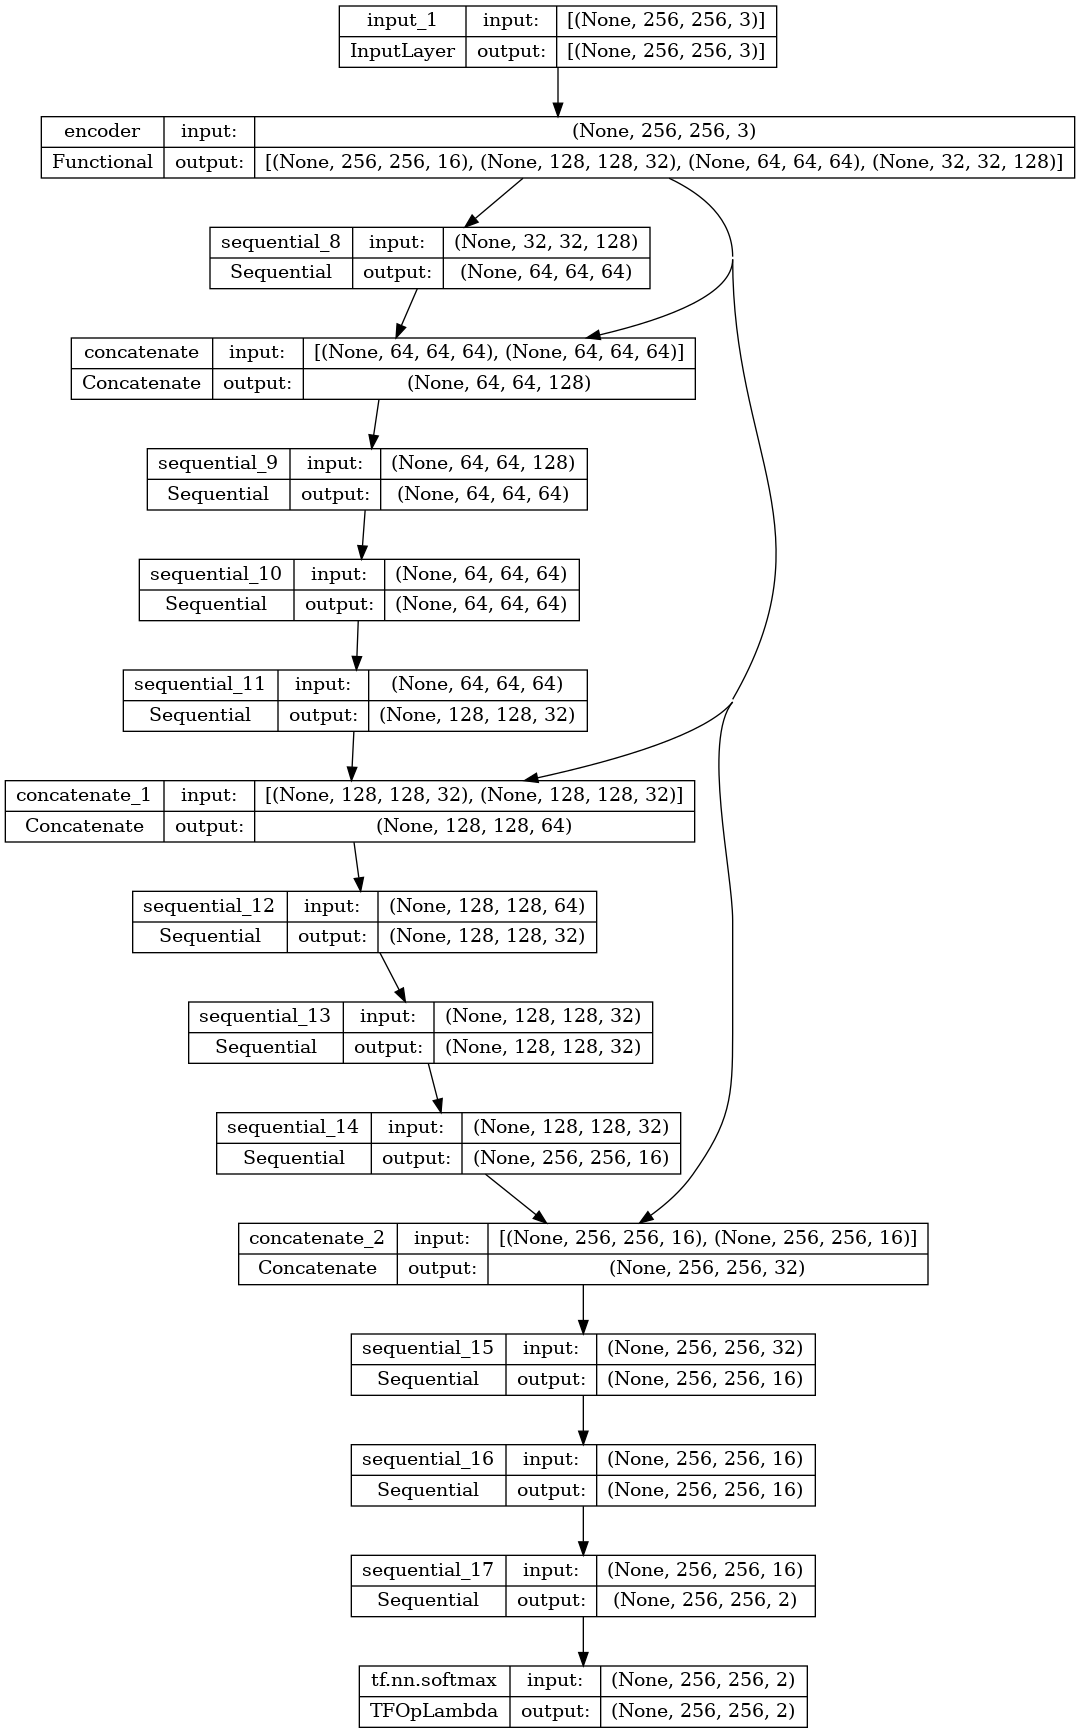

In [ ]:
EPOCHS = 15
STEPS_PER_EPOCH = 150

optimizer = tfa.optimizers.RectifiedAdam(
    learning_rate=0.005,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_proportion=0.3,
    min_lr=0.00001,
)
optimizer = tfa.optimizers.Lookahead(optimizer)

loss = tf.keras.losses.CategoricalCrossentropy()
mIoU = IoU(num_classes=2, target_class_ids=[0, 1], sparse_y_true=False, sparse_y_pred=False, name='mean-IoU')

model = UNetModel(IMG_SHAPE + (3,)).model
model.compile(optimizer=optimizer, 
              loss=loss, # bce_dice_loss,
              metrics=[mIoU, 'binary_accuracy'] ) 

trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print(f'Trainable params: {trainable_params}')

tf.keras.utils.plot_model(model, show_shapes=True)


In [ ]:
model.summary()

Model: "model"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               

                                )]                                                                

                                                                                                  

 encoder (Functional)           [(None, 256, 256, 1  103536      ['input_1[0][0]']                

                                6),                                                               

                                 (None, 128, 128, 3                                               

                                2),                                                               

                                 (None, 64, 64, 64)                                

In [ ]:
#Running the model 

import cv2

checkpoint_filepath = '/content/gdrive/MyDrive/Kaggle/checkpoints/model-checkpoint'
save_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mean-IoU',
    mode='max',
    save_best_only=True
)

early_stop_callback = keras.callbacks.EarlyStopping(
    monitor='val_mean-IoU',
    mode='max',
    patience= 3,
    restore_best_weights=True
)

model_history = model.fit(train_batches,
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=validation_batches,
                          callbacks=[save_callback, early_stop_callback])
model.load_weights(checkpoint_filepath)

Epoch 1/15
150/150 [==============================] - 293s 1s/step - loss: 0.6812 - mean-IoU: 0.3593 - binary_accuracy: 0.7126 - val_loss: 0.6924 - val_mean-IoU: 0.5392 - val_binary_accuracy: 0.9811
Epoch 2/15
150/150 [==============================] - 148s 993ms/step - loss: 0.6014 - mean-IoU: 0.5598 - binary_accuracy: 0.9868 - val_loss: 0.6544 - val_mean-IoU: 0.6442 - val_binary_accuracy: 0.9962
Epoch 3/15
150/150 [==============================] - 150s 1s/step - loss: 0.3654 - mean-IoU: 0.6876 - binary_accuracy: 0.9969 - val_loss: 0.2273 - val_mean-IoU: 0.7085 - val_binary_accuracy: 0.9969
Epoch 4/15
150/150 [==============================] - 138s 922ms/step - loss: 0.1145 - mean-IoU: 0.7005 - binary_accuracy: 0.9971 - val_loss: 0.0520 - val_mean-IoU: 0.6966 - val_binary_accuracy: 0.9962
Epoch 5/15
150/150 [==============================] - 159s 1s/step - loss: 0.0395 - mean-IoU: 0.7210 - binary_accuracy: 0.9974 - val_loss: 0.0280 - val_mean-IoU: 0.7068 - val_binary_accuracy: 0.9966

In [ ]:
#Generating table for epoch values

epochs = range(1, len(model_history.history['loss'])+1)
pd.DataFrame(model_history.history, index=epochs)

,loss,mean-IoU,binary_accuracy,val_loss,val_mean-IoU,val_binary_accuracy
1,0.681201,0.359265,0.712583,0.692399,0.539246,0.981124
2,0.601423,0.559842,0.986842,0.654429,0.644240,0.996241
3,0.365416,0.687638,0.996868,0.227312,0.708534,0.996914
4,0.114546,0.700467,0.997088,0.051966,0.696593,0.996217
5,0.039468,0.720952,0.997415,0.028016,0.706756,0.996564
6,0.021110,0.724760,0.997674,0.017019,0.730504,0.997374
7,0.014863,0.739076,0.997734,0.011690,0.765463,0.997903
8,0.011388,0.752894,0.998034,0.009828,0.741626,0.998027
9,0.009721,0.753546,0.998046,0.008847,0.765915,0.998176
10,0.009351,0.746324,0.997959,0.007671,0.779747,0.998214


In [ ]:
import os
os.mkdir('/kaggle/working/saved_model1')

In [ ]:
#Saving the model

model.save('/kaggle/working/saved_model1/modelnew.h5')

from tensorflow.keras.models import load_model

newmodel = load_model('/kaggle/working/saved_model1/modelnew.h5')

Generating graphs for metrics

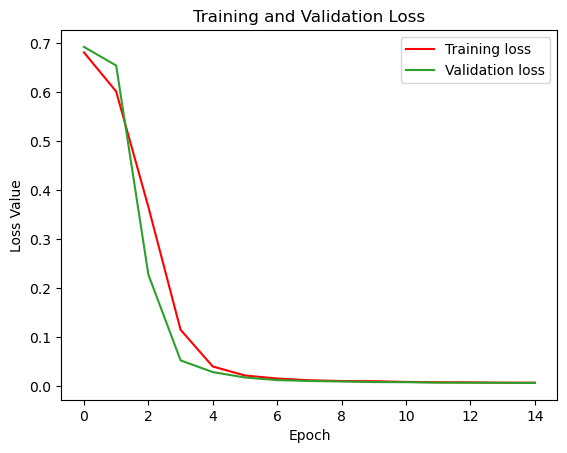

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'C2', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

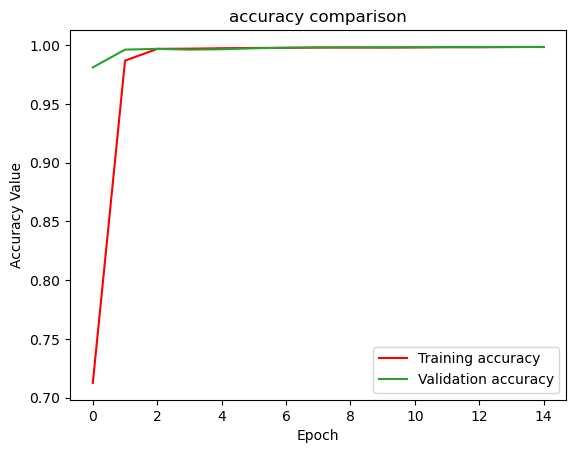

In [ ]:
accuracy = model_history.history['binary_accuracy']
val_accuracy = model_history.history['val_binary_accuracy']

plt.figure()
plt.plot(model_history.epoch, accuracy, 'r', label='Training accuracy')
plt.plot(model_history.epoch, val_accuracy, 'C2', label='Validation accuracy')
plt.title('accuracy comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()

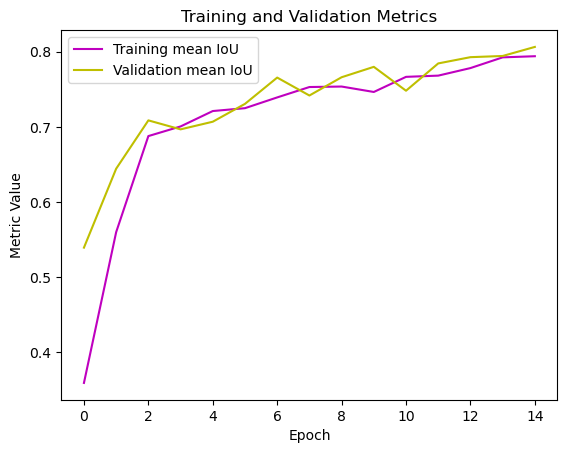

In [ ]:
mIoU = model_history.history['mean-IoU']
val_mIoU = model_history.history['val_mean-IoU']

plt.figure()
plt.plot(model_history.epoch, mIoU, 'm', label='Training mean IoU')
plt.plot(model_history.epoch, val_mIoU, 'y', label='Validation mean IoU')

plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [ ]:
#Predicting the IOU on test set

results = model.evaluate(test_batches)
print("test loss, test mIoU:", results)

125/125 [==============================] - 94s 411ms/step - loss: 0.0063 - mean-IoU: 0.7990 - binary_accuracy: 0.9984
test loss, test mIoU: [0.006311498582363129, 0.7990081310272217, 0.9984083771705627]


AFter predicting on the test set, we are obtaining IOU as 0.79.9 ~ 0.80 
IOU is 80% and accuracy is 99.8 % 

In [ ]:
#Defining predict

def predict(image):
    image = np.expand_dims(image, axis=0)
    pred_mask = model.predict(image)[0].argmax(axis=-1)  
    return pred_mask

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


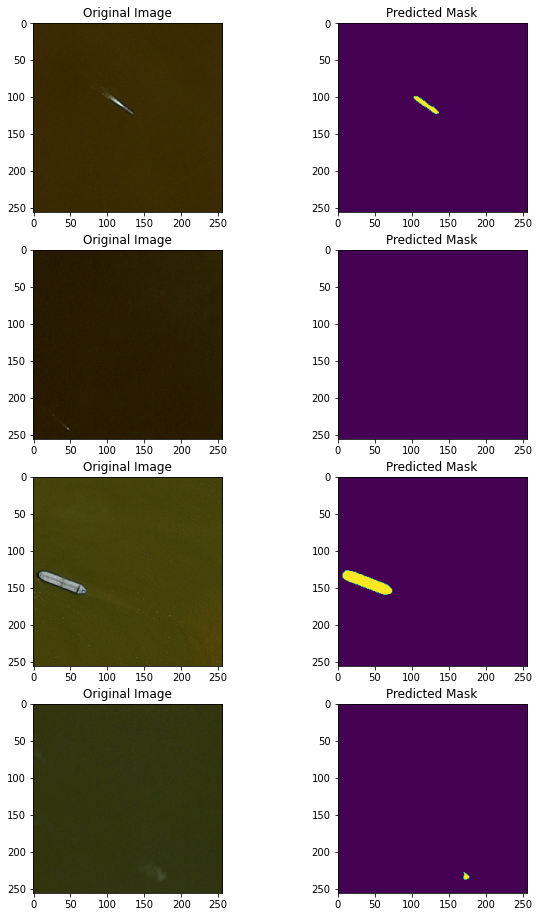

In [ ]:
#Showing the sample of plot predicted on test dataset

N = 4

f, ax = plt.subplots(N, 2, figsize=(10, 4 * N))
i = 0
for image, mask in test_dataset.take(N):
    pred_mask = predict(image)
    ax[i, 0].imshow(image)
    ax[i, 0].set_title('Original Image')
    ax[i, 1].imshow(pred_mask)
    ax[i, 1].set_title('Predicted Mask')
    i += 1

plt.show()


In [ ]:
#Generating submission CSV

import os
os.makedirs('/kaggle/working/new', exist_ok=True)

submission2 = pd.read_csv("/kaggle/input/lab1-part3-imageclassification/sample_submission.csv")

# Read the submission file


# Define a function to apply the model prediction to each row of the submission file
def set_model_prediction(row: pd.Series) -> pd.Series:
    # Read in the image
    image = cv2.imread(f'{TEST_DIR}{row["ImageId"]}')
    # Resize and normalize the image
    if image is not None and len(image) > 0:
        image = cv2.resize(image, IMG_SHAPE, interpolation=cv2.INTER_AREA)
        image = image / 255.0
        # Predict the mask for the image
        pred_mask = predict(image)
        # Convert the mask to RLE format and store it in the EncodedPixels column
        row['EncodedPixels'] = mask_to_rle(pred_mask)
    else:
        # Handle empty or invalid image
        row['EncodedPixels'] = np.nan
    return row

# Apply the set_model_prediction function to each row of the submission file
submission2 = submission2.apply(lambda x: set_model_prediction(x), axis=1).set_index('ImageId')

# Write the modified submission file to disk
submission2.to_csv('/kaggle/working/new/submission2.csv')

# Print the modified submission file
#print(submission2)


Have generated submission csv